In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db

In [6]:
dpd.fetch_bundles_2_subjects()

Data size is approximately 234MB
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/exp_bundles_and_maps 


({'bundles_2_subjects.tar.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/38477/bundles_2_subjects.tar.gz',
   '97756fbef11ce2df31f1bedf1fc7aac7')},
 '/home/ubuntu/.dipy/exp_bundles_and_maps')

In [7]:
ls /home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/

bundles_af.left.trk   bundles_cg.left.trk     bundles_mdlf.right.trk
bundles_af.right.trk  bundles_cg.right.trk    bundles_slf1.left.trk
bundles_cc_1.trk      bundles_cst.left.trk    bundles_slf1.right.trk
bundles_cc_2.trk      bundles_cst.right.trk   bundles_slf2.left.trk
bundles_cc_3.trk      bundles_ifof.left.trk   bundles_slf2.right.trk
bundles_cc_4.trk      bundles_ifof.right.trk  bundles_slf_3.left.trk
bundles_cc_5.trk      bundles_ilf.left.trk    bundles_slf_3.right.trk
bundles_cc_6.trk      bundles_ilf.right.trk   bundles_uf.left.trk
bundles_cc_7.trk      bundles_mdlf.left.trk   bundles_uf.right.trk


In [8]:
bundle_files = glob('/home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/bundles/*.trk')

In [9]:
t1_img = nib.load('/home/ubuntu/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_1/t1_warped.nii.gz')
vol_shape=t1_img.shape
vol_shape

(256, 256, 150)

In [10]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))

In [11]:
bundle_names

['ifof.left',
 'slf_3.right',
 'slf1.right',
 'af.left',
 'cc_3',
 'slf1.left',
 'ilf.left',
 'cc_2',
 'mdlf.left',
 'slf_3.left',
 'cc_1',
 'uf.right',
 'ilf.right',
 'cc_6',
 'cc_5',
 'cc_7',
 'ifof.right',
 'cg.right',
 'slf2.left',
 'cg.left',
 'uf.left',
 'cst.left',
 'cst.right',
 'slf2.right',
 'af.right',
 'mdlf.right',
 'cc_4']

In [12]:
np.min(n_streamlines), len(n_streamlines)

(161, 27)

In [16]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0.2
val_perc=0.2
size_slimage = 100

In [109]:
import imp  
imp.reload(bn)

if op.exists('./subject1_bundles.npz'):
    # Read it from file:
    loaded_from_file = np.load('./subject1_bundles.npz')
    labels_test = loaded_from_file['labels_test']
    labels_train = loaded_from_file['labels_train']
    data_test = loaded_from_file['data_test']
    data_train = loaded_from_file['data_train']
else:
    streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl).compute()
    streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage).compute() 
    data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
    np.savez('./subject1_bundles', data_train=data_train, labels_train=labels_train,data_test=data_test, labels_test=labels_test)

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enab

In [110]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 24
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [111]:
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test  = keras.utils.to_categorical(labels_test, num_classes)
labels_val  = keras.utils.to_categorical(labels_val, num_classes)

In [112]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

In [118]:
labels_train.shape


(2607, 27)

In [119]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=input_shape,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.25))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [120]:
from IPython.display import SVG
from keras.utils import plot_model
#from vis_utils import plot_model
plot_model(model, to_file='model.png')

In [121]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [122]:
filepath="checkpoints/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
#create checkpoints dir
training = model.fit(data_train, labels_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val),
                     callbacks=callbacks_list)

Train on 2607 samples, validate on 870 samples
Epoch 1/24
2607/2607 [==============================] - 49s 19ms/step - loss: 0.0104 - acc: 0.9985 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to checkpoints/weights.best.hdf5
Epoch 2/24
2607/2607 [==============================] - 49s 19ms/step - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/24
2604/2607 [============================>.] - ETA: 0s - loss: 1.1921e-07 - acc: 1.0000

In [107]:
data_test.shape

(870, 100, 100, 1)

In [80]:
model.load_weights("checkpoints/weights.best.hdf5")

In [81]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [82]:
print(score)

[0.2066658722973837, 0.9317129629629629]


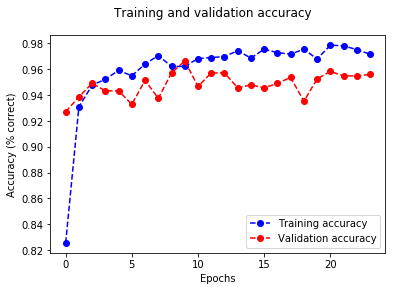

In [83]:
fig = bn.plot_accuracy(training)

In [84]:
p = model.predict(data_test, batch_size=5)

In [116]:
imp.reload(bn)

p_bundles, actual_labels = bn.print_accuarcystats(p,labels_test,bundle_names)

Percent correct is 0.9317129629629629 
Kappa is: 0.9290865384615384
Jaccard is: 0.9317129629629629


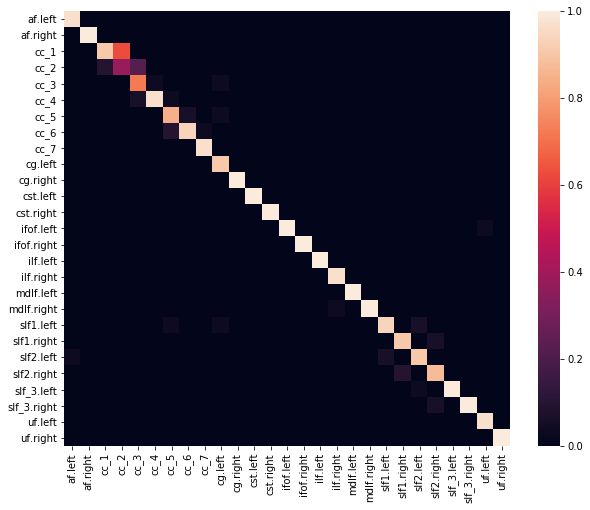

In [122]:
bn.plotconfusionmat(bundle_names, p_bundles, actual_labels)

Cross-predict on *another subject*

In [ ]:
sub2_bundle_files = glob('/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/bundles/*.trk')

In [ ]:
sub2_t1_img = nib.load('/Users/jpowen/.dipy/exp_bundles_and_maps/bundles_2_subjects/subj_2/t1_warped.nii.gz')

In [ ]:
n_streamlines = 0
for fname in sub2_bundle_files:
    streamlines = bn.read_sl(fname)
    n_streamlines += len(streamlines)

In [ ]:
n_streamlines

In [ ]:
if not op.exists('./subject2_bundles_all.npz'):
    data_sub2 = np.zeros((n_streamlines, 100, 100, 1))
    actual_labels = np.zeros(n_streamlines, dtype=np.object)
    ii = 0
    for fname in sub2_bundle_files:
        bundle_name = fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0]
        print(bundle_name)
        streamlines = bn.read_sl(fname)
        structure = morph.generate_binary_structure(3, 1)
        origin = morph._ni_support._normalize_sequence(0, 3)
        structure = structure[tuple([slice(None, None, -1)] *
                                structure.ndim)]                        
        for sl in streamlines: 
            data_sub2[ii] = bn.reduce_sl(sl, t1_img.shape,structure, origin)
            if not np.mod(ii, 100):
                print("ii = %s"%ii)
            actual_labels[ii] = bundle_name
            ii += 1

    np.savez('./subject2_bundles_all', data_sub2=data_sub2, actual_labels=actual_labels)
else: 
    from_file = np.load('./subject2_bundles_all.npz')
    data_sub2 = from_file['data_sub2']
    actual_labels = from_file['actual_labels']

In [ ]:
p = model.predict(data_sub2, batch_size=5)

In [ ]:
p_idx = np.argmax(p, axis=-1)

In [ ]:
p_bundles = [bundle_names[ii] for ii in p_idx]

In [ ]:
print("Percent correct is %s " % np.mean(p_bundles == actual_labels))
kappa = cohen_kappa_score(p_bundles, actual_labels)
print("Kappa is: %s" % kappa)
jaccard = jaccard_similarity_score(p_bundles, actual_labels)
print("Jaccard is: %s" % jaccard)

In [ ]:
np.mean(p_bundles == actual_labels)

In [ ]:
confusion = np.zeros((len(bundle_names), len(bundle_names)))
arr_bundle_names = np.array(bundle_names)
for xx in range(len(p_bundles)):
    idx1 = np.where(arr_bundle_names == p_bundles[xx])
    idx2 = np.where(arr_bundle_names == actual_labels[xx])
    n = np.sum(actual_labels == actual_labels[xx])
    confusion[idx1, idx2] += 1 / n

In [ ]:
sort_idx = np.argsort(arr_bundle_names)

In [ ]:
fig, ax = plt.subplots(1)
sns.heatmap(confusion[sort_idx][:, sort_idx],
            xticklabels=arr_bundle_names[sort_idx], 
            yticklabels=arr_bundle_names[sort_idx], ax=ax)
fig.set_size_inches([10, 8])

In [ ]:
p_error = p[~(p_bundles == actual_labels)]
p_correct = p[p_bundles == actual_labels]

In [ ]:
fig, ax = plt.subplots(1)
ax.hist(np.max(p_correct, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Correct")
ax.hist(np.max(p_error, -1), histtype='step', linewidth=2, normed=True, bins=10, label="Incorrect")
ax.set_xlabel("Probability of chosen category")
ax.set_ylabel("Normalized frequency")
plt.legend(loc="upper left")

In [70]:
sl = bn.read_sl("/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwiDTI_det_streamlines.trk")

In [71]:
dwi_img = nib.load('/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/sub-01_sess-01_dwi_b0.nii.gz')
vol_shape_dwi=dwi_img.shape
vol_shape_dwi

(81, 106, 76)

In [88]:
imp.reload(bn)

stan_loaded = db.from_sequence(["/home/ubuntu/stanford_hardi/derivatives/afq/sub-01/sess-01/clean_bundles/UNC_L.trk"]).map(bn.read_sl).compute()
stan_streamlines_processed = db.from_sequence(stan_loaded).map(bn.process_sl,100,vol_shape_dwi,size_slimage).compute() 
tmp = stan_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0))) 

SyntaxError: invalid syntax (<ipython-input-88-b5c67a454368>, line 6)

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


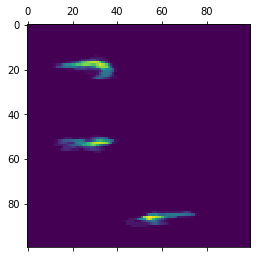

In [86]:
atlas_loaded = db.from_sequence([bundle_files[11]]).map(bn.read_sl).compute()
atlas_streamlines_processed = db.from_sequence(atlas_loaded).map(bn.process_sl,100,vol_shape,size_slimage).compute() 
tmp = atlas_streamlines_processed[0]
plt.matshow(np.squeeze(np.sum(tmp,axis=0)))